In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from scipy import sparse

import warnings
warnings.filterwarnings('ignore') 
from sklearn.exceptions import UndefinedMetricWarning

from wordcloud import WordCloud

from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler 

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

from xgboost import XGBClassifier
from xgboost import plot_tree, plot_importance

import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [2]:
df = pd.read_csv('./cache/data.csv', encoding='utf-8')
print(df.shape)
df.head()

(17985, 5)


,date,News,GICS Sector,Label1Sig,Label2Sig
0,2010-01-05,These images depict the untouched stomach cont...,Consumer Discretionary,0.0,0.0
1,2010-01-05,These images depict the untouched stomach cont...,Consumer Staples,0.0,0.0
2,2010-01-05,These images depict the untouched stomach cont...,Energy,0.0,0.0
3,2010-01-05,These images depict the untouched stomach cont...,Financials,1.0,0.0
4,2010-01-05,These images depict the untouched stomach cont...,Health Care,0.0,0.0


In [3]:
X=df.iloc[:,[0,2,1]]
y=df.iloc[:,3]
sigma='Label1Sig'

## 3.1 Visualize the negative and positive words

In [4]:
neg_words = []
neg_phrases = df[df[sigma] == -1]['News'].values
for phrase in neg_phrases:
    for word in phrase.split():
        neg_words.append(word)
neg_text = pd.Series(neg_words).str.cat(sep=' ')
neg_text[:100]

'These images depict the untouched stomach contents of baby birds in one of the worlds most remote ma'

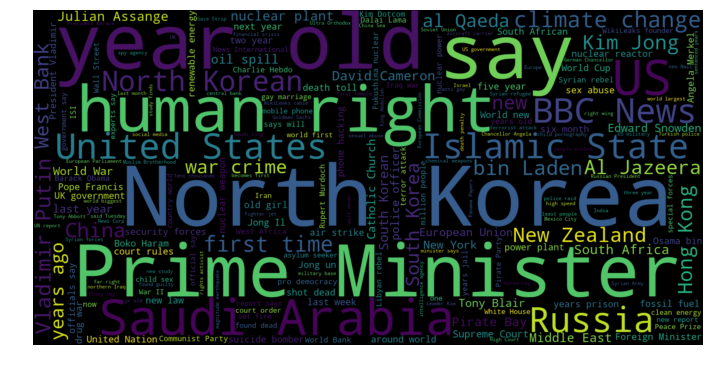

In [5]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [6]:
pos_words = []
pos_phrases = df[df[sigma] == 1]['News'].values
for phrase in pos_phrases:
    for word in phrase.split():
        pos_words.append(word)
pos_text = pd.Series(pos_words).str.cat(sep=' ')
pos_text[:100]

'These images depict the untouched stomach contents of baby birds in one of the worlds most remote ma'

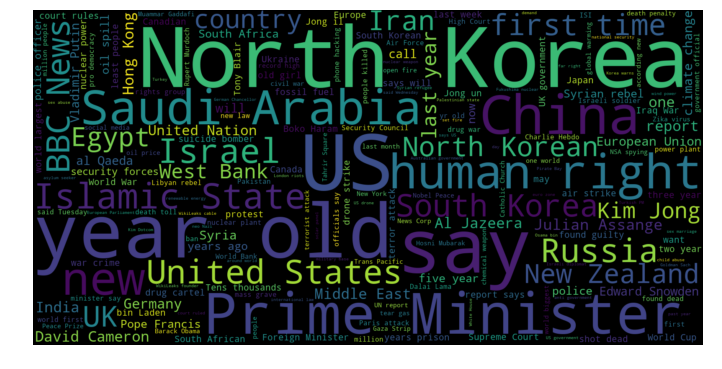

In [7]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(pos_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## 3.2 Tokenize text

In [8]:
cv = CountVectorizer(stop_words='english', ngram_range=(2,3), max_features=10000, lowercase=True, token_pattern=r'\b[^\d\W]+\b')
tv = TfidfVectorizer(analyzer='word',min_df=0.0, max_df=1.0, ngram_range=(2,3), token_pattern=r'\w{1,}', sublinear_tf=True, max_features=10000)

In [9]:
cv.fit(df['News'])
tv.fit(df['News'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=10000,
                min_df=0.0, ngram_range=(2, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=True, token_pattern='\\w{1,}', tokenizer=None,
                use_idf=True, vocabulary=None)

## 3.2.2 Run algorithm using Decision Tree Classifier

In [10]:
model = DecisionTreeClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_test.tail()

,date,GICS Sector,News
8951,2013-04-01,Real Estate,Cyprus President's Family Transferred Tens Of ...
4520,2011-08-19,Utilities,Japanese police say people have returned $78 m...
15672,2015-09-01,Real Estate,"Canada officially in recession, Cuba goes all ..."
2992,2011-02-02,Consumer Discretionary,Clashes have broke out between pro and anti-go...
10479,2013-10-16,Materials,France finds Church of Scientology guilty of o...


In [11]:
''' 
Vectorize text takes in a vectorizer such as CountVectorizer or TfidVectorizer 
and transforms the text into features
'''
def vectorize_text(vector, train_x, test_x):
    train_features = vector.transform(train_x['News'])
    test_features = vector.transform(test_x['News'])
    return train_features, test_features

'''
Simple model to fit the training features utilizing a given model and make predictions
'''
def train_model(model, train_vect_x, train_y, test_vect_x):
    model = model.fit(train_vect_x, train_y)
    return model.predict(test_vect_x)

In [12]:
train_vect_x, test_vect_x = vectorize_text(tv, X_train, X_test)
predictions = train_model(model, train_vect_x, y_train, test_vect_x)

## 3.2 Evaluation metrics

### 3.2.1 Sklearn scoring metrics

#### Score test takes in name/label to the scores and then wrongs a couple scoring models against them for comparison:
Accuracy: overall accuracy of classification
Precision: True Positive/(True Positive + False Positive)
Recall: True Positive/(True Positive + False Negative)
F1 Score: 2x Precision*Recall/(Precision+Recall)
Cohen kappa: (total accuracy - random accuracy)/(1 - random accuracy)
    Cohen's kappa is always less than or equal to 1.  Values of 0 or less, indicate that the classifier is useless.
    Values:
        <0           No agreement
        0-0.20       Slight
        0.21-0.40    Fair
        0.41-0.60    Moderate
        0.61-0.80    Substantial
        0.81-1.00    Perfect agreement

##### In the case of Financial stocks where we are determining whether to buy or sell a stock.  Quality is more important than quality.  It is better to be precise and specific about what we buy and sell then to correctly classify all data.  For the purpose of this evaluation Accuracy and Precision are the most important metrics.  As you will see the Cohen's kappa will be a combination of these 2 scores and is a good single measure for scoring this data

Kampakis, Dr. Stylianos (2016).  Performance Measures: Cohen's Kappa Statistic.  Retrieved on May 8, 2016 
from https://thedatascientist.com/performance-measures-cohens-kappa-statistic/

In [151]:
def score_test(name, y_test, y_predict):
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, labels=[-1,1], average='weighted')
    recall = recall_score(y_test, predictions, labels=[-1,1], average='weighted')
    f1 = f1_score(y_test, predictions, labels=[-1,1], average='weighted')
    if len(y_test.unique()) > 1:
        cohen = cohen_kappa_score(y_test, predictions, labels=[-1,1])
    else:
        cohen = 'n/a'
    return {'Name': name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1, 'Cappa': cohen}

In [14]:
score_test('Initial', y_test, predictions)

{'Name': 'Initial',
 'Accuracy': 0.8109838274932615,
 'Precision': 0.6449936106622733,
 'Recall': 0.5178451178451179,
 'F1': 0.570994436727997,
 'Cappa': 0.9682356769068083}

### 3.2.2 Stock scoring metrics

#### Classifies predictions based on whether it is a good or bad buy/hold/sell:
Label: Label that identifies the row in table
Good/Bad: Indicates whether the purchase or sale of stock was a good or bad choice<br>
    Good:<br>
        &emsp;Buy - Indicates predicted purchase was a good choice and would have made a profit<br>
        &emsp;Sell - Indicates predicted sell was a good choice and would have saved money<br>
        &emsp;Hold - Indicates that holding the stock or not purchasing the stock was a good choice<br>
        &emsp;Miss - 0 value.  Only applies to bad section.<br>
        &emsp;Total - Total good choices<br>
    Bad:<br>
        &emsp;Buy - Indicates predicted purchase was a bad choice and would have resulted in a loss<br>
        &emsp;Sell - Indicates predicted sell was a bad choice and would have resulted in loss of profit<br>
        &emsp;Hold - Indicates that predicted hold was a bad choice and would have resulted in missed profit or loss of money<br>
        &emsp;Miss - Indicates that predicted buy/sell transaction resulted in no change in stock price<br>
        &emsp;Total - Total bad choices<br>
    Total - totals of the good and bad choices for each column<br>
    True% - percentage of good and bad choices<br>
        
##### In my observation in order to maximize investment.  You would like to make good choices of when to buy and sell.  The higher the ratio of good buy/sell options you make the better you are to invest.  

Bad holds are ok because you will never be able to predict all the stocks that will go up and down.  In terms of the Miss category, these are transactions that netted no real change.  If you have many Misses you will take hit on transaction fees

As a small investor you will be hit with transaction fees the more investments you make.  When listening to traders they say it is much more important to minimize risk.  The ones that take high risk receive high reward but do not last

In [158]:
def stock_score(label, y_test, y_predict):
    conf_matrix = pd.crosstab(y_test, predictions, rownames=["Actual"], colnames=["Predicted"])
    if conf_matrix.shape[0] < 3 | conf_matrix.shape[1] < 3:
        return   # if predictions are all 1 value then do not print
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
        conf_arr = [
            {
                'Label': label, 'Good/Bad': 'Good',
                'Buy': conf_matrix.get(1,{}).get(1,0),
                'Sell': conf_matrix.get(-1,{}).get(-1,0),
                'Hold': conf_matrix.get(0,{}).get(0,0),
                'Miss': 0,
                'Total': conf_matrix.get(1,{}).get(1,0)+conf_matrix.get(-1,{}).get(-1,0)+conf_matrix.get(0,{}).get(0,0)
            },
            {
                'Label': label, 'Good/Bad': 'Bad',
                'Buy': conf_matrix.get(1,{}).get(-1,0),
                'Sell': conf_matrix.get(-1,{}).get(1,0),
                'Hold': conf_matrix.get(0,{}).get(1,0)+conf_matrix.get(0,{}).get(-1,0),
                'Miss': conf_matrix.get(1,{}).get(0,0)+conf_matrix.get(-1,{}).get(0,0),
                'Total': conf_matrix.get(1,{}).get(-1,0)+conf_matrix.get(-1,{}).get(1,0)+conf_matrix.get(0,{}).get(1,0)+conf_matrix.get(0,{}).get(-1,0)+conf_matrix.get(1,{}).get(0,0)+conf_matrix.get(-1,{}).get(0,0)
            }
        ]
        conf_arr.append({'Label': label+' Total', 'Good/Bad': '',
                        'Buy': conf_arr[0]['Buy'] + conf_arr[1]['Buy'],
                        'Sell': conf_arr[0]['Sell'] + conf_arr[1]['Sell'],
                        'Hold': conf_arr[0]['Hold'] + conf_arr[1]['Hold'],
                        'Miss': conf_arr[0]['Miss'] + conf_arr[1]['Miss'],
                        'Total': conf_arr[0]['Total'] + conf_arr[1]['Total']
                        })
        conf_arr.append({'Label': label+' %', 'Good/Bad': 'True%',
                        'Buy': round(100*conf_arr[0]['Buy'] / conf_arr[2]['Buy'] if conf_arr[2]['Buy'] else 0),
                        'Sell': round(100*conf_arr[0]['Sell'] / conf_arr[2]['Sell'] if conf_arr[2]['Sell'] else 0),
                        'Hold': round(100*conf_arr[0]['Hold'] / conf_arr[2]['Hold']),
                        'Miss': round(100*conf_arr[1]['Miss'] / conf_arr[2]['Hold']),
                        'Total': round(100*conf_arr[0]['Total'] / conf_arr[2]['Total'])
                        })
        return conf_arr

In [16]:
conf_df = pd.DataFrame(columns=['Label', 'Good/Bad','Buy','Sell','Hold','Miss','Total'])
conf_df = conf_df.append(stock_score('Initial', y_test, predictions), ignore_index=True)
conf_df

,Label,Good/Bad,Buy,Sell,Hold,Miss,Total
0,Initial,Good,314.0,455.0,4045.0,0.0,4814.0
1,Initial,Bad,4.0,8.0,704.0,406.0,4451.0
2,Initial Total,,318.0,463.0,4749.0,406.0,9265.0
3,Initial %,True%,99.0,98.0,85.0,9.0,52.0


### 3.2.3 Excellent score, further evaluation for scientific purposes to be done
#### This is an excellent score.  Cappa is almost perfect at 96%.  Accuracy is above 80%.  The only thing that could be better is the precision which is only at 64%.  99% good buys and 98% good sells.  However there were 406 missed classification of transactions that resulted in no change.

#### Unfortunately, it does not factor time-based splitting.  When making actual predictions you cannot randomly go to previous dates you are forecasting future dates.

Other methods experiments:
- Run data against XGBoost which worked better than Decision in Baseline
- Split the data by sector see if overfitting to the specific sector will help
- Undersampling algorithm.  Run undersampling whih will increase the recall but how will it affect the precision
- Time series forecasting.  Try both an expanded and rolling window to see if metrics that change over time are a good indicator

## 3.2.4 XGBoost classifier

In [17]:
score_df = pd.DataFrame(columns=['Name', 'Accuracy','Precision','Recall','F1','Cappa'])
conf_df = pd.DataFrame(columns=['Label', 'Good/Bad','Buy','Sell','Hold','Miss','Total'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model = XGBClassifier()
train_vect_x, test_vect_x = vectorize_text(tv, X_train, X_test)
predictions = train_model(model, train_vect_x, y_train, test_vect_x)

score = score_test('XGB', y_test, predictions)
score_df = score_df.append(score, ignore_index=True)
conf_df = conf_df.append(stock_score('XGB', y_test, predictions))

In [18]:
score_df

,Name,Accuracy,Precision,Recall,F1,Cappa
0,XGB,0.764825,0.791653,0.080135,0.145502,0.983193


In [19]:
conf_df

,Label,Good/Bad,Buy,Sell,Hold,Miss,Total
0,XGB,Good,54.0,65.0,4421.0,0.0,4540.0
1,XGB,Bad,1.0,0.0,1365.0,30.0,4451.0
2,XGB Total,,55.0,65.0,5786.0,30.0,8991.0
3,XGB %,True%,98.0,100.0,76.0,1.0,50.0


#### XGBoost vs DecisionTree
XGBoost did a better job being more precise than DecisionTree.  The precision went up from 64 to 79% and cappa went from 96 to 98%.  However, the accuracy went down from 81 to 76%.  

While the accuracy did go down the Extreme Gradient Boost was more precise in its predictions.  Fewer predictions led to only 1 bad buy and the misses dropped from 9 to 1%.  

Result: 150 transactions.  55 made profit, 65 limited loss and 30 did nothing

## 3.3 Split stocks by sector

In [20]:
sectors = X_train['GICS Sector'].unique()

In [21]:
X_train[X_train['GICS Sector'] == 'Materials'].head()

,date,GICS Sector,News
5144,2011-11-09,Materials,Italy's Berlusconi Agrees To Resign After Pass...
8763,2013-03-06,Materials,"Venezuela's Hugo Chavez dead at 58, Chinese Fa..."
843,2010-04-26,Materials,European push to ban burqas appalls Afghan wom...
10325,2013-09-26,Materials,"Iran's new president: Yes, the Holocaust happe..."
9478,2013-06-07,Materials,EFF has so much evidence of the NSA surveillan...


In [22]:
score_df = pd.DataFrame(columns=['Name', 'Accuracy','Precision','Recall','F1','Cappa'])
conf_df = pd.DataFrame(columns=['Label', 'Good/Bad','Buy','Sell','Hold','Miss','Total'])
for sector in sectors:
    print(sector)
    X_sector = df[df['GICS Sector'] == sector].iloc[:,[0,2,1]]
    y_sector = df[df['GICS Sector'] == sector].iloc[:,3]
    X_train, X_test, y_train, y_test = train_test_split(X_sector, y_sector, test_size=0.33, random_state=42)
    model = XGBClassifier()
    train_vect_x, test_vect_x = vectorize_text(tv, X_train, X_test)
    predictions = train_model(model, train_vect_x, y_train, test_vect_x)
    score = score_test(sector, y_test, predictions)
    score_df = score_df.append(score, ignore_index=True)
    conf_df = conf_df.append(stock_score(sector, y_test, predictions))

Materials
Health Care
Financials
Real Estate
Information Technology
Consumer Discretionary
Consumer Staples
Energy
Telecommunications Services
Industrials
Utilities


In [23]:
score_df.sort_values(by=['Cappa'])

,Name,Accuracy,Precision,Recall,F1,Cappa
6,Consumer Staples,0.731481,0.000000,0.000000,0.000000,-1.0
9,Industrials,0.737037,0.085784,0.007353,0.013545,-0.5
1,Health Care,0.714815,0.000000,0.000000,0.000000,0.0
5,Consumer Discretionary,0.740741,0.347826,0.014493,0.027605,0.4
8,Telecommunications Services,0.720370,0.193452,0.013889,0.025835,1.0
0,Materials,0.751852,0.276119,0.007463,0.014533,NaN
2,Financials,0.750000,0.000000,0.000000,0.000000,NaN
3,Real Estate,0.746296,0.180247,0.007407,0.014230,NaN
4,Information Technology,0.709259,0.000000,0.000000,0.000000,NaN
7,Energy,0.742593,0.000000,0.000000,0.000000,NaN


In [24]:
score_df.describe()

,Accuracy,Precision,Recall,F1,Cappa
count,11.000000,11.000000,11.000000,11.000000,5.000000
mean,0.734175,0.098494,0.004600,0.008704,-0.020000
std,0.014257,0.129532,0.005786,0.010923,0.775887
min,0.709259,0.000000,0.000000,0.000000,-1.000000
25%,0.725926,0.000000,0.000000,0.000000,-0.500000
50%,0.737037,0.000000,0.000000,0.000000,0.000000
75%,0.744444,0.186850,0.007435,0.014381,0.400000
max,0.751852,0.347826,0.014493,0.027605,1.000000


In [25]:
conf_df[conf_df['Good/Bad'] == 'True%']

,Label,Good/Bad,Buy,Sell,Hold,Miss,Total
3,Materials %,True%,100.0,0,75.0,0.0,50.0
3,Health Care %,True%,0.0,0,72.0,1.0,50.0
3,Financials %,True%,0.0,0,75.0,0.0,50.0
3,Real Estate %,True%,100.0,0,75.0,1.0,50.0
3,Information Technology %,True%,0.0,0,71.0,0.0,50.0
3,Consumer Discretionary %,True%,100.0,50,75.0,1.0,50.0
3,Consumer Staples %,True%,0.0,0,74.0,0.0,50.0
3,Energy %,True%,0.0,0,75.0,1.0,50.0
3,Telecommunications Services %,True%,100.0,100,73.0,2.0,50.0
3,Industrials %,True%,50.0,0,75.0,1.0,50.0


#### Modeling by sector shows is either good or bad at classifying certain sectors
XGBoost did a good job classifying Telecommunications, Materials, Real Estate and Consumer Discretionary but it struggled on classifying what to sell.  Even Telecommunications had several misses.  

Therefore, we will not limit our algorithm to a single sector but rather to the market as a whole

### 3.3.2 Visualization of the Dataset for one sector
For visualization purposes I have decided to show the data for one sector to show how it came out

In [26]:
sector = 'Telecommunications Services'
tv = TfidfVectorizer(analyzer='word',min_df=0.0, max_df=1.0, ngram_range=(2,3), token_pattern=r'\w{1,}', sublinear_tf=True, max_features=10000)
tv.fit(df['News'])
X_sector = df[df['GICS Sector'] == sector].iloc[:,[0,2,1]]
y_sector = df[df['GICS Sector'] == sector].iloc[:,3]
X_train, X_test, y_train, y_test = train_test_split(X_sector, y_sector, test_size=0.33, random_state=42)
model = XGBClassifier()
train_vect_x, test_vect_x = vectorize_text(tv, X_train, X_test)
model = model.fit(train_vect_x, y_train)
predictions = model.predict(test_vect_x)
score = score_test(sector, y_test, predictions)

In [27]:
score

{'Name': 'Telecommunications Services',
 'Accuracy': 0.7203703703703703,
 'Precision': 0.19345238095238093,
 'Recall': 0.013888888888888888,
 'F1': 0.02583482076453964,
 'Cappa': 1.0}

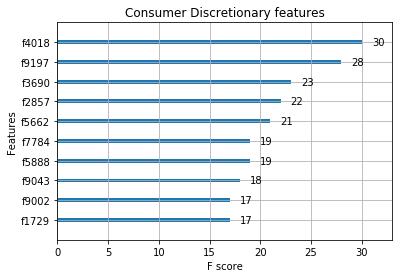

In [28]:
plot_importance(model, importance_type='weight', max_num_features=10, title='Consumer Discretionary features')
plt.show()

In [29]:
data = {'Feature': tv.get_feature_names(), 'Score': model.feature_importances_}
feature_df = pd.DataFrame(data)
feature_df.sort_values(by=['Score'], ascending=False).head(10)

,Feature,Score
9081,tons of,0.005256
8824,to meet,0.005092
2547,euros in,0.004809
8931,to secure,0.004716
1183,as protesters,0.004593
9544,ways to,0.004567
2104,country s,0.004564
1800,canada to,0.004548
2880,for war crimes,0.004529
987,and wales,0.004516


In [30]:
feature_df.iloc[4018,:]

Feature        in the
Score      0.00205926
Name: 4018, dtype: object

In [31]:
model.feature_importances_[4018]

0.0020592574

### 3.3.3 Visualize words for whole market

In [32]:
tv = TfidfVectorizer(analyzer='word',min_df=0.0, max_df=1.0, ngram_range=(2,3), token_pattern=r'\w{1,}', sublinear_tf=True, max_features=10000)
tv.fit(df['News'])
X = df.iloc[:,[0,2,1]]
y = df.iloc[:,3]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model = XGBClassifier()
train_vect_x, test_vect_x = vectorize_text(tv, X_train, X_test)
model = model.fit(train_vect_x, y_train)
predictions = model.predict(test_vect_x)
score = score_test(sector, y_test, predictions)

In [33]:
score

{'Name': 'Telecommunications Services',
 'Accuracy': 0.7648247978436657,
 'Precision': 0.7916531452277573,
 'Recall': 0.08013468013468013,
 'F1': 0.14550216658510315,
 'Cappa': 0.9831932773109243}

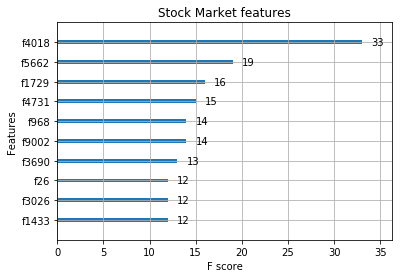

In [34]:
plot_importance(model, importance_type='weight', max_num_features=10, title='Stock Market features')
plt.show()

In [35]:
data = {'Feature': tv.get_feature_names(), 'Score': model.feature_importances_}
feature_df = pd.DataFrame(data)
feature_df.sort_values(by=['Score'], ascending=False).head(10)

,Feature,Score
7456,t a,0.004768
4502,japanese government,0.004444
5891,on the grounds,0.004072
7721,the blockade,0.003994
955,and says,0.003967
1575,blair s,0.003932
9447,wanted to,0.003892
7916,the greeks,0.003889
6460,r n,0.003862
1929,chinese police,0.003859


### 3.3.4 Visualize the words in a Word Cloud

In [36]:
neg_words = []
neg_phrases = df[(df[sigma] == -1) & (df['GICS Sector'] == 'Materials')]['News'].values
for phrase in neg_phrases:
    for word in phrase.split():
        neg_words.append(word)
neg_text = pd.Series(neg_words).str.cat(sep=' ')
neg_text[:100]

'Why would a former Guantanamo Bay prison guard track down two of his former captives - two British m'

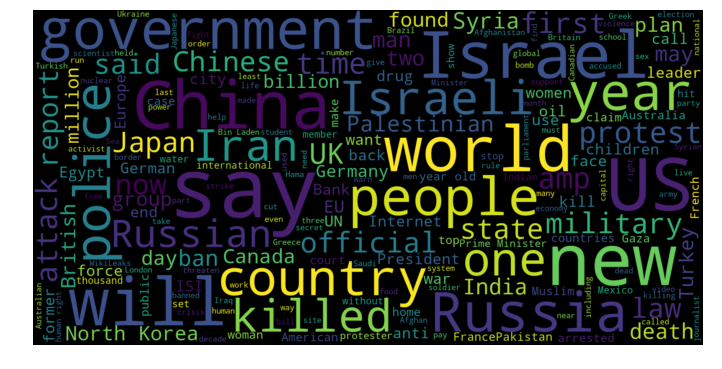

In [37]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [38]:
pos_words = []
pos_phrases = df[(df[sigma] == 1) & (df['GICS Sector'] == 'Materials')]['News'].values
for phrase in pos_phrases:
    for word in phrase.split():
        pos_words.append(word)
pos_text = pd.Series(pos_words).str.cat(sep=' ')
pos_text[:100]

"Haiti Struck By Major Earthquake for 2nd Time in 8 Days', We\\'ve all seen and heard reports of compl"

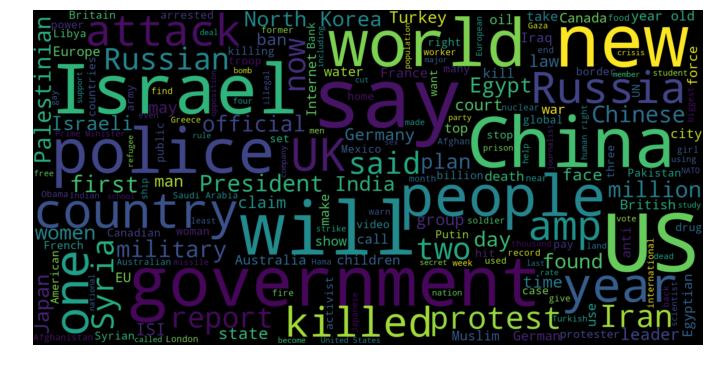

In [39]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(pos_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## 3.4 Undersampling
Attempt to use undersampling to see if it will lead to better accuracy and precision

In [40]:
# only sample majority
sampling_strategy='majority'

samplers = []
samplers.append(('RND', RandomUnderSampler(sampling_strategy))) 
samplers.append(('CC', ClusterCentroids(sampling_strategy)))
samplers

[('RND', RandomUnderSampler(random_state=None, ratio=None, replacement=False,
                     return_indices=False, sampling_strategy='majority')),
 ('CC',
  ClusterCentroids(estimator=None, n_jobs=1, random_state=None, ratio=None,
                   sampling_strategy='majority', voting='auto'))]

In [42]:
score_df = pd.DataFrame(columns=['Name', 'Accuracy','Precision','Recall','F1','Cappa'])
conf_df = pd.DataFrame(columns=['Label', 'Good/Bad','Buy','Sell','Hold','Miss','Total'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
train_vect_x, test_vect_x = vectorize_text(tv, X_train, X_test)
for name, sampler in samplers:
    print(name)
    X_sampled, y_sampled = sampler.fit_sample(train_vect_x.toarray(), y_train)

    model = XGBClassifier()
    predictions = train_model(model, X_sampled, y_sampled, test_vect_x)
    score = score_test(name, y_test, predictions)
    score_df = score_df.append(score, ignore_index=True)
    conf_df = conf_df.append(stock_score(name,y_test,predictions))

RND
CC


In [43]:
score_df

,Name,Accuracy,Precision,Recall,F1,Cappa
0,RND,0.590465,0.337166,0.690236,0.447922,0.810120
1,CC,0.747642,0.444553,0.058586,0.103296,0.827273


In [44]:
score_df.describe()

,Accuracy,Precision,Recall,F1,Cappa
count,2.000000,2.000000,2.000000,2.000000,2.000000
mean,0.669053,0.390860,0.374411,0.275609,0.818696
std,0.111141,0.075934,0.446644,0.243687,0.012129
min,0.590465,0.337166,0.058586,0.103296,0.810120
25%,0.629759,0.364013,0.216498,0.189453,0.814408
50%,0.669053,0.390860,0.374411,0.275609,0.818696
75%,0.708347,0.417707,0.532323,0.361766,0.822985
max,0.747642,0.444553,0.690236,0.447922,0.827273


In [45]:
conf_df

,Label,Good/Bad,Buy,Sell,Hold,Miss,Total
0,RND,Good,443.0,582.0,2480.0,0.0,3505.0
1,RND,Bad,26.0,80.0,354.0,1971.0,4451.0
2,RND Total,,469.0,662.0,2834.0,1971.0,7956.0
3,RND %,True%,94.0,88.0,88.0,70.0,44.0
0,CC,Good,51.0,36.0,4351.0,0.0,4438.0
1,CC,Bad,4.0,4.0,1390.0,100.0,4451.0
2,CC Total,,55.0,40.0,5741.0,100.0,8889.0
3,CC %,True%,93.0,90.0,76.0,2.0,50.0


#### Undersampling improves recall but worses precision and accuracy
Undersampling did help improve the recall but made the accuracy and precison 10%.  The Cappa score shows that undersampling only led to a negative classification.  More than half the stocks were missclassified as buy/sell.

## 3.4 Time-based split for stocks

### Split in time-based train and test
In reality, when predicting stock prices you will not be able to do a normal random sampling like we did at the start of this exercise.  You are trying to forecast whether to buy/sell future stocks based on previous sentiment history.

So, in order to truly test you need to do a Time-based split.

### 3.4.1 Split based on 70/30 cutoff date
Split the data based on a specified date in time which will have a 70/30 ratio

In [46]:
# Reset the data to do Time windows
X=df.iloc[:,[0,2,1]]
y=df.iloc[:,[0,3]]

tv = TfidfVectorizer(analyzer='word',min_df=0.0, max_df=1.0, ngram_range=(2,3), token_pattern=r'\w{1,}', sublinear_tf=True, max_features=10000)
tv_features = tv.fit_transform(X['News'])
combined_df = pd.DataFrame(tv_features.toarray(), columns=tv.get_feature_names())
combined_df = pd.concat([X.iloc[:,:2], combined_df], axis=1)
combined_df['GICS Sector'] = 0.9+0.01*pd.Categorical(combined_df['GICS Sector']).codes

In [47]:
combined_df.head()

,date,GICS Sector,0 earthquake,000 000,000 a,000 and,000 dead,000 euros,000 for,000 in,...,young girls,young man,young men,young people,young woman,youth unemployment,yr old,zealand s,zika virus,zimbabwe s
0,2010-01-05,0.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-01-05,0.91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-01-05,0.92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2010-01-05,0.93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2010-01-05,0.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
ddates = combined_df['date'].unique()
cutoff = ddates[int(len(ddates)*.7)]
X_train_time = combined_df[combined_df['date'] <= cutoff]
y_train_time = y[y['date'] <= cutoff][sigma]
X_test_time = combined_df[combined_df['date'] > cutoff]
y_test_time = y[y['date'] > cutoff][sigma]

In [49]:
X_test_time.shape

(5390, 10002)

In [50]:
score_df = pd.DataFrame(columns=['Name', 'Accuracy','Precision','Recall','F1','Cappa'])
conf_df = pd.DataFrame(columns=['Label', 'Good/Bad','Buy','Sell','Hold','Miss','Total'])

model = XGBClassifier()
label = 'Split'
predictions = train_model(model, X_train_time.iloc[:,1:], y_train_time, X_test_time.iloc[:,1:])
score = score_test(label, y_test_time, predictions)
score_df = score_df.append(score, ignore_index=True)
conf_df = conf_df.append(stock_score(label,y_test_time,predictions))

In [51]:
pd.crosstab(y_test_time, predictions, rownames=["Actual"], colnames=["Predicted"])

Predicted,-1.0,0.0,1.0
Actual,,,
-1.0,0,718,0
0.0,7,3937,1
1.0,1,718,8


In [52]:
score_df

,Name,Accuracy,Precision,Recall,F1,Cappa
0,Split,0.731911,0.447213,0.005536,0.010937,0.0


In [53]:
conf_df

,Label,Good/Bad,Buy,Sell,Hold,Miss,Total
0,Split,Good,8.0,0.0,3937.0,0.0,3945.0
1,Split,Bad,0.0,1.0,1436.0,8.0,3945.0
2,Split Total,,8.0,1.0,5373.0,8.0,7890.0
3,Split %,True%,100.0,0.0,73.0,0.0,50.0


In [54]:
data = {'Date': X_test_time.index, 'Actual': y_test_time, 'Predictions': predictions }
plot_df = pd.DataFrame(data)
plot_df = plot_df.groupby('Date').agg('mean')
plot_df.head()

,Actual,Predictions
Date,,
12595,0.0,0.0
12596,0.0,0.0
12597,0.0,0.0
12598,0.0,0.0
12599,0.0,0.0


In [55]:
plt_data = []
plt_data.append(go.Scatter(
    x = plot_df.index.values,
    y = plot_df['Actual'].values,
    name = 'Actual'
))
plt_data.append(go.Scatter(
    x = plot_df.index.values,
    y = plot_df['Predictions'].values,
    name = 'Predictions'
))
layout = go.Layout(dict(title = 'Actual vs Predicted stocks',
                       xaxis = dict(title = 'Month'),
                       yaxis = dict(title = 'Price'),
                       ), legend = dict(orientation = 'h'))
py.iplot(dict(data=plt_data, layout=layout), filename='basic-line')

### 3.4.2 Attempt with DecisionTree instead

In [56]:
score_df = pd.DataFrame(columns=['Name', 'Accuracy','Precision','Recall','F1','Cappa'])
conf_df = pd.DataFrame(columns=['Label', 'Good/Bad','Buy','Sell','Hold','Miss','Total'])

model = DecisionTreeClassifier()
label = 'Split'
predictions = train_model(model, X_train_time.iloc[:,1:], y_train_time, X_test_time.iloc[:,1:])
score = score_test(label, y_test_time, predictions)
score_df = score_df.append(score, ignore_index=True)
conf_df = conf_df.append(stock_score(label,y_test_time,predictions))

In [57]:
pd.crosstab(y_test_time, predictions, rownames=["Actual"], colnames=["Predicted"])

Predicted,-1.0,0.0,1.0
Actual,,,
-1.0,111,509,98
0.0,592,2901,452
1.0,126,531,70


In [58]:
score_df

,Name,Accuracy,Precision,Recall,F1,Cappa
0,Split,0.5718,0.123334,0.12526,0.123596,-0.112255


In [59]:
conf_df[conf_df['Good/Bad'] == 'True%']

,Label,Good/Bad,Buy,Sell,Hold,Miss,Total
3,Split %,True%,42.0,47.0,74.0,26.0,44.0


In [60]:
data = {'Date': X_test_time['date'], 'Actual': y_test_time, 'Predictions': predictions }
plot_df = pd.DataFrame(
    data)
plot_df = plot_df.groupby('Date').agg('mean')
plot_df.head()

,Actual,Predictions
Date,,
2014-07-24,0.000000,0.909091
2014-07-25,0.000000,0.090909
2014-07-28,0.090909,0.000000
2014-07-29,-0.454545,0.363636
2014-07-30,-0.272727,0.181818


In [61]:
plt_data = []
plt_data.append(go.Scatter(
    x = plot_df.index.values,
    y = plot_df['Actual'].values,
    name = 'Actual'
))
plt_data.append(go.Scatter(
    x = plot_df.index.values,
    y = plot_df['Predictions'].values,
    name = 'Predictions'
))
layout = go.Layout(dict(title = 'Actual vs Predicted stocks',
                       xaxis = dict(title = 'Month'),
                       yaxis = dict(title = 'Price'),
                       ), legend = dict(orientation = 'h'))
py.iplot(dict(data=plt_data, layout=layout), filename='basic-line')

#### Decision Tree better than XGBoost

When it came to classifying the data in a time based algorithm it looks like Decision Tree is classifying more than XGBoost whereas XGBoost is better at being more precise.  For both the expanded window and rolling window we will try both.

### 3.4.3 Run Expanded Window forecasting

#### 3.4.3.1 Create train test validation split
Utilize the expanding window methodology to split the training data into 7 parts.  After each iteration the training model expands its window to incorporate more data

In [62]:
tscv = TimeSeriesSplit(n_splits=7)
def time_train_test_split(start_date, split_date, stop_date):
    print('train', start_date, split_date, stop_date)
    X_train_time = X[(X['date'] >= start_date) & (X['date'] < split_date)]
    y_train_time = y[(y['date'] >= start_date) & (y['date'] < split_date)][sigma]
    X_test_time = X[(X['date'] >= split_date) & (X['date'] < stop_date)]
    y_test_time = y[(y['date'] >= split_date) & (y['date'] < stop_date)][sigma]
    return X_train_time, X_test_time, y_train_time, y_test_time

#### 3.4.3.2 XGBoost with expanded window

In [64]:
score_df = pd.DataFrame(columns=['Name', 'Accuracy','Precision','Recall','F1','Cappa'])
conf_df = pd.DataFrame(columns=['Label', 'Good/Bad','Buy','Sell','Hold','Miss','Total'])

ddates = X['date'].unique()
for train_index, test_index in tscv.split(ddates):
    # Split data by train, validation and test.  Use the validation step to tune
    X_train_time, X_test_time, y_train_time, y_test_time = time_train_test_split(ddates[train_index[0]], ddates[test_index[0]], ddates[test_index[-1]])  
    # Get TF-IDF on all the data
#     train_vect_x, test_vect_x = vectorize_text(tv, X_train_time, X_test_time)
    tv_train_features = tv.fit_transform(X_train_time['News'])
    X_train_df = pd.DataFrame(tv_train_features.toarray(), columns=tv.get_feature_names())
    X_train_df = pd.concat([X_train_time.iloc[:,:2], X_train_df], axis=1)
    X_train_df['GICS Sector'] = 0.9+0.01*pd.Categorical(X_train_df['GICS Sector']).codes
    
    tv_test_features = tv.transform(X_test_time['News'])
    X_test_df = pd.DataFrame(X_test_time.iloc[:,:2].values, columns=['date', 'GICS Sector'])
    X_test_df = pd.concat([X_test_df, pd.DataFrame(tv_test_features.toarray(), columns=tv.get_feature_names())], axis=1)
    X_test_df['GICS Sector'] = 0.9+0.01*pd.Categorical(X_test_df['GICS Sector']).codes
    
    model = XGBClassifier()
    label = str(ddates[train_index[-1]])
    predictions = train_model(model, X_train_df.iloc[:,1:], y_train_time, X_test_df.iloc[:,1:])
    score = score_test(label, y_test_time, predictions)
    score_df = score_df.append(score, ignore_index=True)
    conf_df = conf_df.append(stock_score(label,y_test_time,predictions))

train 2010-01-05 2010-10-29 2011-08-19
train 2010-01-05 2011-08-22 2012-06-12
train 2010-01-05 2012-06-13 2013-04-08
train 2010-01-05 2013-04-09 2014-01-28
train 2010-01-05 2014-01-29 2014-11-17
train 2010-01-05 2014-11-18 2015-09-10
train 2010-01-05 2015-09-11 2016-07-01


In [65]:
pd.crosstab(y_test_time,predictions, rownames=["Actual"], colnames=["Predicted"])

Predicted,0.0,1.0
Actual,,
-1.0,274,0
0.0,1576,1
1.0,374,8


In [66]:
score_df

,Name,Accuracy,Precision,Recall,F1,Cappa
0,2010-10-28,0.734438,0.256375,0.015464,0.029168,-0.130435
1,2011-08-19,0.663681,0.645007,0.026178,0.050304,0.673469
2,2012-06-12,0.800717,0.000000,0.000000,0.000000,NaN
3,2013-04-08,0.789073,0.064552,0.013793,0.022729,0.000000
4,2014-01-28,0.781460,0.086569,0.006383,0.011889,NaN
5,2014-11-17,0.755934,0.000000,0.000000,0.000000,NaN
6,2015-09-10,0.709360,0.517615,0.012195,0.023829,NaN


In [67]:
score_df.describe()

,Accuracy,Precision,Recall,F1,Cappa
count,7.000000,7.000000,7.000000,7.000000,3.000000
mean,0.747809,0.224303,0.010573,0.019703,0.181012
std,0.049049,0.261141,0.009324,0.017747,0.431439
min,0.663681,0.000000,0.000000,0.000000,-0.130435
25%,0.721899,0.032276,0.003191,0.005945,-0.065217
50%,0.755934,0.086569,0.012195,0.022729,0.000000
75%,0.785266,0.386995,0.014629,0.026499,0.336735
max,0.800717,0.645007,0.026178,0.050304,0.673469


In [68]:
conf_df[conf_df['Good/Bad'] == 'True%']

,Label,Good/Bad,Buy,Sell,Hold,Miss,Total
3,2010-10-28 %,True%,0.0,90.0,74.0,1.0,50.0
3,2011-08-19 %,True%,69.0,100.0,66.0,0.0,50.0
3,2012-06-12 %,True%,0.0,0.0,82.0,2.0,49.0
3,2013-04-08 %,True%,0.0,33.0,81.0,2.0,49.0
3,2014-01-28 %,True%,100.0,0.0,79.0,1.0,50.0
3,2014-11-17 %,True%,0.0,0.0,76.0,0.0,50.0
3,2015-09-10 %,True%,100.0,0.0,71.0,0.0,50.0


#### XGBoost and Expanded Window Time Series did not properly classify
We again attempted XGBoost this time with exapanded window split and unfortunately it had the same advantages of limiting the classifications but ran into no sell predictions.  The precision was low at 22% and cappa at 18%.

#### 3.4.3.3 DecionTreeClassifier with Expanded Window

In [69]:
X_train_df.iloc[:,1:].head()

,GICS Sector,0 earthquake,000 000,000 a,000 and,000 dead,000 euros,000 for,000 in,000 jobs,...,young girls,young man,young men,young people,young woman,youth unemployment,youtube video,yr old,zealand s,zimbabwe s
0,0.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
score_df = pd.DataFrame(columns=['Name', 'Accuracy','Precision','Recall','F1','Cappa'])
conf_df = pd.DataFrame(columns=['Label', 'Good/Bad','Buy','Sell','Hold','Miss','Total'])

ddates = X['date'].unique()
for train_index, test_index in tscv.split(ddates):
    # Split data by train, validation and test.  Use the validation step to tune
    X_train_time, X_test_time, y_train_time, y_test_time = time_train_test_split(ddates[train_index[0]], ddates[test_index[0]], ddates[test_index[-1]])  

    # Get TF-IDF on all the data
    tv_train_features = tv.fit_transform(X_train_time['News'])
    X_train_df = pd.DataFrame(tv_train_features.toarray(), columns=tv.get_feature_names())
    X_train_df = pd.concat([X_train_time.iloc[:,:2], X_train_df], axis=1)
    X_train_df['GICS Sector'] = 0.9+0.01*pd.Categorical(X_train_df['GICS Sector']).codes
    
    tv_test_features = tv.transform(X_test_time['News'])
    X_test_df = pd.DataFrame(X_test_time.iloc[:,:2].values, columns=['date', 'GICS Sector'])
    X_test_df = pd.concat([X_test_df, pd.DataFrame(tv_test_features.toarray(), columns=tv.get_feature_names())], axis=1)
    X_test_df['GICS Sector'] = 0.9+0.01*pd.Categorical(X_test_df['GICS Sector']).codes

    model = DecisionTreeClassifier()
    label = str(ddates[train_index[-1]])
    predictions = train_model(model, X_train_df.iloc[:,1:], y_train_time, X_test_df.iloc[:,1:])
    score = score_test(label, y_test_time, predictions)
    score_df = score_df.append(score, ignore_index=True)
    conf_df = conf_df.append(stock_score(label,y_test_time,predictions))

train 2010-01-05 2010-10-29 2011-08-19
train 2010-01-05 2011-08-22 2012-06-12
train 2010-01-05 2012-06-13 2013-04-08
train 2010-01-05 2013-04-09 2014-01-28
train 2010-01-05 2014-01-29 2014-11-17
train 2010-01-05 2014-11-18 2015-09-10
train 2010-01-05 2015-09-11 2016-07-01


In [71]:
pd.crosstab(y_test_time,predictions, rownames=["Actual"], colnames=["Predicted"])

Predicted,-1.0,0.0,1.0
Actual,,,
-1.0,82,164,28
0.0,262,1096,219
1.0,73,268,41


In [72]:
score_df

,Name,Accuracy,Precision,Recall,F1,Cappa
0,2010-10-28,0.550828,0.158661,0.192440,0.173824,0.229219
1,2011-08-19,0.501567,0.197020,0.214660,0.202327,0.044038
2,2012-06-12,0.582624,0.075458,0.137755,0.097417,-0.132738
3,2013-04-08,0.629646,0.120299,0.167816,0.140099,0.050392
4,2014-01-28,0.553515,0.085444,0.134043,0.104349,-0.134432
5,2014-11-17,0.589342,0.138089,0.150459,0.143516,0.008568
6,2015-09-10,0.545902,0.165034,0.187500,0.170400,0.104355


In [73]:
score_df.describe()

,Accuracy,Precision,Recall,F1,Cappa
count,7.000000,7.000000,7.000000,7.000000,7.000000
mean,0.564775,0.134286,0.169239,0.147419,0.024200
std,0.040421,0.043840,0.030330,0.038001,0.128825
min,0.501567,0.075458,0.134043,0.097417,-0.134432
25%,0.548365,0.102871,0.144107,0.122224,-0.062085
50%,0.553515,0.138089,0.167816,0.143516,0.044038
75%,0.585983,0.161847,0.189970,0.172112,0.077373
max,0.629646,0.197020,0.214660,0.202327,0.229219


In [74]:
conf_df[conf_df['Good/Bad'] == 'True%']

,Label,Good/Bad,Buy,Sell,Hold,Miss,Total
3,2010-10-28 %,True%,54.0,69.0,74.0,35.0,43.0
3,2011-08-19 %,True%,50.0,55.0,68.0,36.0,43.0
3,2012-06-12 %,True%,42.0,45.0,82.0,39.0,41.0
3,2013-04-08 %,True%,52.0,53.0,82.0,29.0,44.0
3,2014-01-28 %,True%,35.0,51.0,78.0,39.0,41.0
3,2014-11-17 %,True%,35.0,66.0,76.0,28.0,44.0
3,2015-09-10 %,True%,59.0,53.0,72.0,31.0,44.0


#### Decision Tree classifier with Expanded window 
Even with decision tree it is unable to give a good classification to the stock sectors.  You can see that the predictions do get better/worse during certain periods.  For instance the first 4 splits had a slight classification but then it went in opposite direction in 2014.  That could mean that there was a change in the world news in 2014 that skewed the results.

In [75]:
data = {'Date': X_test_time['date'], 'Actual': y_test_time, 'Predictions': predictions }
plot_df = pd.DataFrame(data)
plot_df.index = pd.to_datetime(plot_df['Date'].values, format='%Y-%m-%d')
plot_df = plot_df.groupby(pd.Grouper(freq='M')).sum()
# plot_df.head()

In [76]:
plt_data = []
plt_data.append(go.Scatter(
    x = plot_df.index.values,
    y = plot_df['Actual'].values,
    name = 'Actual'
))
plt_data.append(go.Scatter(
    x = plot_df.index.values,
    y = plot_df['Predictions'].values,
    name = 'Predictions'
))
layout = go.Layout(dict(title = 'Actual vs Predicted stocks',
                       xaxis = dict(title = 'Month'),
                       yaxis = dict(title = 'Price'),
                       ), legend = dict(orientation = 'h'))
py.iplot(dict(data=plt_data, layout=layout), filename='basic-line')

### 3.4.3 Rolling window forecasting

In [77]:
X_train_df.shape
y_train_time.shape

(15741,)

In [78]:
score_df = pd.DataFrame(columns=['Name', 'Accuracy','Precision','Recall','F1','Cappa'])
conf_df = pd.DataFrame(columns=['Label', 'Good/Bad','Buy','Sell','Hold','Miss','Total'])

# X=df.iloc[:,[0,2,1]]
# y=df.iloc[:,[0,3]]

# tv = TfidfVectorizer(analyzer='word',min_df=0.0, max_df=1.0, ngram_range=(2,3), token_pattern=r'\w{1,}', sublinear_tf=True, max_features=10000)
# tv.fit(X['News'])

step = 90
walkforward=30
ddates = X['date'].unique()
for index in range(step, len(ddates), step):
    if (index+walkforward) > len(ddates):
        break #for not going over index out of range
    
    X_train_time, X_test_time, y_train_time, y_test_time = time_train_test_split(ddates[index-step], ddates[index], ddates[index+walkforward])  

    tv_train_features = tv.fit_transform(X_train_time['News'])
    X_train_df = pd.DataFrame(X_train_time.iloc[:,:2].values, columns=['date', 'GICS Sector'])
    X_train_df = pd.concat([X_train_df, pd.DataFrame(tv_train_features.toarray(), columns=tv.get_feature_names())], axis=1)
    X_train_df['GICS Sector'] = 0.9+0.01*pd.Categorical(X_train_df['GICS Sector']).codes
   
    tv_test_features = tv.transform(X_test_time['News'])
    X_test_df = pd.DataFrame(X_test_time.iloc[:,:2].values, columns=['date', 'GICS Sector'])
    X_test_df = pd.concat([X_test_df, pd.DataFrame(tv_test_features.toarray(), columns=tv.get_feature_names())], axis=1)
    X_test_df['GICS Sector'] = 0.9+0.01*pd.Categorical(X_test_df['GICS Sector']).codes

    # Get TF-IDF on all the data
    train_vect_x, test_vect_x = vectorize_text(tv, X_train_time, X_test_time)

    #X_sampled, y_sampled = sampler.fit_sample(train_vect_x, y_train_sect)

    model = XGBClassifier()
    label = str(ddates[index-step])
    predictions = train_model(model, X_train_df.iloc[:,1:], y_train_time, X_test_df.iloc[:,1:])
    score = score_test(label, y_test_time, predictions)
    score_df = score_df.append(score, ignore_index=True)
    conf_df = conf_df.append(stock_score(label,y_test_time,predictions))

train 2010-01-05 2010-05-14 2010-06-28
train 2010-05-14 2010-09-22 2010-11-03
train 2010-09-22 2011-01-31 2011-03-15
train 2011-01-31 2011-06-09 2011-07-22
train 2011-06-09 2011-10-17 2011-11-29
train 2011-10-17 2012-02-27 2012-04-10
train 2012-02-27 2012-07-05 2012-08-16
train 2012-07-05 2012-11-13 2012-12-27
train 2012-11-13 2013-03-26 2013-05-08
train 2013-03-26 2013-08-02 2013-09-16
train 2013-08-02 2013-12-10 2014-01-24
train 2013-12-10 2014-04-22 2014-06-04
train 2014-04-22 2014-08-28 2014-10-10
train 2014-08-28 2015-01-07 2015-02-20
train 2015-01-07 2015-05-18 2015-06-30
train 2015-05-18 2015-09-24 2015-11-05
train 2015-09-24 2016-02-03 2016-03-17


In [79]:
pd.crosstab(y_test_time,predictions, rownames=["Actual"], colnames=["Predicted"])

Predicted,0.0,1.0
Actual,,
-1.0,35,0
0.0,206,3
1.0,85,1


In [80]:
score_df

,Name,Accuracy,Precision,Recall,F1,Cappa
0,2010-01-05,0.381818,0.198529,0.004902,0.009568,NaN
1,2010-05-14,0.793939,0.122004,0.117647,0.119786,-0.142857
2,2010-09-22,0.718182,0.000000,0.000000,0.000000,NaN
3,2011-01-31,0.706061,0.000000,0.000000,0.000000,NaN
4,2011-06-09,0.566667,0.123547,0.077519,0.095265,-0.510441
5,2011-10-17,0.900000,0.000000,0.000000,0.000000,NaN
6,2012-02-27,0.796970,0.000000,0.000000,0.000000,0.000000
7,2012-07-05,0.821212,0.000000,0.000000,0.000000,NaN
8,2012-11-13,0.769697,0.000000,0.000000,0.000000,NaN
9,2013-03-26,0.842424,0.000000,0.000000,0.000000,0.000000


In [81]:
score_df.describe()

,Accuracy,Precision,Recall,F1,Cappa
count,17.000000,17.000000,17.000000,17.000000,6.000000
mean,0.731729,0.045442,0.014107,0.017172,-0.108883
std,0.128877,0.069649,0.032729,0.035586,0.204854
min,0.381818,0.000000,0.000000,0.000000,-0.510441
25%,0.666667,0.000000,0.000000,0.000000,-0.107143
50%,0.769697,0.000000,0.000000,0.000000,0.000000
75%,0.824242,0.085926,0.008264,0.015794,0.000000
max,0.900000,0.198529,0.117647,0.119786,0.000000


In [82]:
conf_df[conf_df['Good/Bad'] == 'True%']

,Label,Good/Bad,Buy,Sell,Hold,Miss,Total
3,2010-01-05 %,True%,100.0,0,38.0,0.0,50.0
3,2010-05-14 %,True%,86.0,0,86.0,8.0,48.0
3,2010-09-22 %,True%,0.0,0,72.0,0.0,50.0
3,2011-01-31 %,True%,0.0,0,71.0,0.0,50.0
3,2011-06-09 %,True%,48.0,0,64.0,9.0,48.0
3,2011-10-17 %,True%,0.0,0,90.0,0.0,50.0
3,2012-02-27 %,True%,0.0,0,82.0,0.0,50.0
3,2012-07-05 %,True%,0.0,0,82.0,0.0,50.0
3,2012-11-13 %,True%,0.0,0,77.0,0.0,50.0
3,2013-03-26 %,True%,0.0,0,87.0,2.0,49.0


In [83]:
conf_df[conf_df['Good/Bad'] == 'Good'].sum()[2:] / conf_df[conf_df['Good/Bad'] == ''].sum()[2:]

Buy           0.6
Sell     0.103448
Hold     0.747438
Miss            0
Total    0.496013
dtype: object

In [84]:
data = {'Date': X_test_time['date'], 'Actual': y_test_time, 'Predictions': predictions }
plot_df = pd.DataFrame(data)
plot_df = plot_df.groupby('Date').agg('mean')
plot_df['Actual'].values[:5]

array([ 0.09090909,  0.18181818, -0.63636364, -0.54545455,  0.54545455])

In [85]:
plt_data = []
plt_data.append(go.Scatter(
    x = plot_df.index.values,
    y = plot_df['Actual'].values,
    name = 'Actual'
))
plt_data.append(go.Scatter(
    x = plot_df.index.values,
    y = plot_df['Predictions'].values,
    name = 'Predictions'
))
layout = go.Layout(dict(title = 'Actual vs Predicted stocks',
                       xaxis = dict(title = 'Month'),
                       yaxis = dict(title = 'Price'),
                       ), legend = dict(orientation = 'h'))
py.iplot(dict(data=plt_data, layout=layout), filename='basic-line')

### 3.4.3.2 Rolling window with Decision Tree Analysis

In [86]:
X_train_df.shape
y_train_time.shape

(990,)

In [87]:
score_df = pd.DataFrame(columns=['Name', 'Accuracy','Precision','Recall','F1','Cappa'])
conf_df = pd.DataFrame(columns=['Label', 'Good/Bad','Buy','Sell','Hold','Miss','Total'])

# X=df.iloc[:,[0,2,1]]
# y=df.iloc[:,[0,3]]

# tv = TfidfVectorizer(analyzer='word',min_df=0.0, max_df=1.0, ngram_range=(2,3), token_pattern=r'\w{1,}', sublinear_tf=True, max_features=10000)
# tv.fit(X['News'])

step = 90
walkforward=30
ddates = X['date'].unique()
for index in range(step, len(ddates), step):
    if (index+walkforward) > len(ddates):
        break #for not going over index out of range
    
    X_train_time, X_test_time, y_train_time, y_test_time = time_train_test_split(ddates[index-step], ddates[index], ddates[index+walkforward])  

    tv_train_features = tv.fit_transform(X_train_time['News'])
    X_train_df = pd.DataFrame(X_train_time.iloc[:,:2].values, columns=['date', 'GICS Sector'])
    X_train_df = pd.concat([X_train_df, pd.DataFrame(tv_train_features.toarray(), columns=tv.get_feature_names())], axis=1)
    X_train_df['GICS Sector'] = 0.9+0.01*pd.Categorical(X_train_df['GICS Sector']).codes
   
    tv_test_features = tv.transform(X_test_time['News'])
    X_test_df = pd.DataFrame(X_test_time.iloc[:,:2].values, columns=['date', 'GICS Sector'])
    X_test_df = pd.concat([X_test_df, pd.DataFrame(tv_test_features.toarray(), columns=tv.get_feature_names())], axis=1)
    X_test_df['GICS Sector'] = 0.9+0.01*pd.Categorical(X_test_df['GICS Sector']).codes

    # Get TF-IDF on all the data
    train_vect_x, test_vect_x = vectorize_text(tv, X_train_time, X_test_time)

    #X_sampled, y_sampled = sampler.fit_sample(train_vect_x, y_train_sect)

    model = DecisionTreeClassifier()
    label = str(ddates[index-step])
    predictions = train_model(model, X_train_df.iloc[:,1:], y_train_time, X_test_df.iloc[:,1:])
    score = score_test(label, y_test_time, predictions)
    score_df = score_df.append(score, ignore_index=True)
    conf_df = conf_df.append(stock_score(label,y_test_time,predictions))

train 2010-01-05 2010-05-14 2010-06-28
train 2010-05-14 2010-09-22 2010-11-03
train 2010-09-22 2011-01-31 2011-03-15
train 2011-01-31 2011-06-09 2011-07-22
train 2011-06-09 2011-10-17 2011-11-29
train 2011-10-17 2012-02-27 2012-04-10
train 2012-02-27 2012-07-05 2012-08-16
train 2012-07-05 2012-11-13 2012-12-27
train 2012-11-13 2013-03-26 2013-05-08
train 2013-03-26 2013-08-02 2013-09-16
train 2013-08-02 2013-12-10 2014-01-24
train 2013-12-10 2014-04-22 2014-06-04
train 2014-04-22 2014-08-28 2014-10-10
train 2014-08-28 2015-01-07 2015-02-20
train 2015-01-07 2015-05-18 2015-06-30
train 2015-05-18 2015-09-24 2015-11-05
train 2015-09-24 2016-02-03 2016-03-17


In [88]:
pd.crosstab(y_test_time,predictions, rownames=["Actual"], colnames=["Predicted"])

Predicted,-1.0,0.0,1.0
Actual,,,
-1.0,9,23,3
0.0,21,164,24
1.0,9,64,13


In [89]:
score_df

,Name,Accuracy,Precision,Recall,F1,Cappa
0,2010-01-05,0.384848,0.310444,0.186275,0.213515,-0.130469
1,2010-05-14,0.515152,0.065776,0.176471,0.095571,-0.058824
2,2010-09-22,0.624242,0.148566,0.053763,0.059247,0.037736
3,2011-01-31,0.600000,0.160596,0.113402,0.131422,-0.061538
4,2011-06-09,0.509091,0.115960,0.108527,0.112121,-0.317280
5,2011-10-17,0.630303,0.026794,0.181818,0.046706,0.000000
6,2012-02-27,0.718182,0.027778,0.015152,0.019608,-0.428571
7,2012-07-05,0.509091,0.143735,0.355932,0.203736,0.450237
8,2012-11-13,0.712121,0.502024,0.039474,0.057792,0.285714
9,2013-03-26,0.727273,0.076667,0.088889,0.082206,0.545455


In [90]:
score_df.describe()

,Accuracy,Precision,Recall,F1,Cappa
count,17.000000,17.000000,17.000000,17.000000,17.000000
mean,0.612299,0.183417,0.137482,0.127259,0.127638
std,0.102955,0.148373,0.097099,0.096042,0.373850
min,0.384848,0.026794,0.015152,0.019608,-0.428571
25%,0.521212,0.076667,0.076923,0.059247,-0.061538
50%,0.624242,0.143735,0.108527,0.095571,0.000000
75%,0.712121,0.284433,0.181818,0.203736,0.306122
max,0.751515,0.502024,0.355932,0.397927,0.904545


In [91]:
conf_df[conf_df['Good/Bad'] == 'True%']

,Label,Good/Bad,Buy,Sell,Hold,Miss,Total
3,2010-01-05 %,True%,46.0,40.0,43.0,18.0,50.0
3,2010-05-14 %,True%,36.0,57.0,84.0,62.0,38.0
3,2010-09-22 %,True%,100.0,25.0,73.0,13.0,47.0
3,2011-01-31 %,True%,54.0,40.0,72.0,18.0,46.0
3,2011-06-09 %,True%,0.0,37.0,65.0,20.0,46.0
3,2011-10-17 %,True%,0.0,55.0,90.0,42.0,41.0
3,2012-02-27 %,True%,25.0,0.0,79.0,9.0,47.0
3,2012-07-05 %,True%,69.0,77.0,83.0,70.0,38.0
3,2012-11-13 %,True%,50.0,100.0,77.0,7.0,48.0
3,2013-03-26 %,True%,50.0,100.0,86.0,18.0,46.0


In [92]:
conf_df[conf_df['Good/Bad'] == 'Good'].sum()[2:] / conf_df[conf_df['Good/Bad'] == ''].sum()[2:]

Buy      0.549451
Sell     0.544118
Hold     0.753799
Miss            0
Total    0.451617
dtype: object

In [93]:
data = {'Date': X_test_time['date'], 'Actual': y_test_time, 'Predictions': predictions }
plot_df = pd.DataFrame(data)
plot_df = plot_df.groupby('Date').agg('mean')
plot_df['Actual'].values[:5]

array([ 0.09090909,  0.18181818, -0.63636364, -0.54545455,  0.54545455])

In [94]:
plt_data = []
plt_data.append(go.Scatter(
    x = plot_df.index.values,
    y = plot_df['Actual'].values,
    name = 'Actual'
))
plt_data.append(go.Scatter(
    x = plot_df.index.values,
    y = plot_df['Predictions'].values,
    name = 'Predictions'
))
layout = go.Layout(dict(title = 'Actual vs Predicted stocks',
                       xaxis = dict(title = 'Month'),
                       yaxis = dict(title = 'Price'),
                       ), legend = dict(orientation = 'h'))
py.iplot(dict(data=plt_data, layout=layout), filename='basic-line')

#### Time split and Classifier selection
In terms of time split algorithms the Rolling Window with Decision Tree seemed to have the best results.  While XGBoost had a better score it had minimal predictions and was unable to classify sells.

## 3.5 Run rolling window by sector
Run the rolling window by individual sector.

### 3.5.1 Methods

In [171]:
tscv = TimeSeriesSplit(n_splits=7)
def time_train_test_split_xy(X,y,start_date, split_date, stop_date):
#     print('train', start_date, split_date, stop_date)
    X_train_time = X[(X['date'] >= start_date) & (X['date'] < split_date)]
    y_train_time = y[(y['date'] >= start_date) & (y['date'] < split_date)][sigma]
    X_test_time = X[(X['date'] >= split_date) & (X['date'] < stop_date)]
    y_test_time = y[(y['date'] >= split_date) & (y['date'] < stop_date)][sigma]
    return X_train_time, X_test_time, y_train_time, y_test_time

In [183]:
def process_sector(sector):
    score_df = pd.DataFrame(columns=['Name', 'Accuracy','Precision','Recall','F1','Cappa'])
    conf_df = pd.DataFrame(columns=['Label', 'Good/Bad','Buy','Sell','Hold','Miss','Total'])

    X=df[df['GICS Sector'] == sector].iloc[:,[0,2,1]]
    y=df[df['GICS Sector'] == sector].iloc[:,[0,3]]
    
    step = 90
    walkforward=30
    ddates = X['date'].unique()
    for index in range(step, len(ddates), step):
        if (index+walkforward) > len(ddates):
            break #for not going over index out of range

        X_train_time, X_test_time, y_train_time, y_test_time = time_train_test_split_xy(X,y,ddates[index-step], ddates[index], ddates[index+walkforward])  

        tv_train_features = tv.fit_transform(X_train_time['News'])
        X_train_df = pd.DataFrame(tv_train_features.toarray(), columns=tv.get_feature_names())

        tv_test_features = tv.transform(X_test_time['News'])
        X_test_df = pd.DataFrame(tv_test_features.toarray(), columns=tv.get_feature_names())

        # Get TF-IDF on all the data
        train_vect_x, test_vect_x = vectorize_text(tv, X_train_time, X_test_time)

        #X_sampled, y_sampled = sampler.fit_sample(train_vect_x, y_train_sect)

        model = DecisionTreeClassifier()
        label = str(ddates[index-step])
        predictions = train_model(model, X_train_df.iloc[:,1:], y_train_time, X_test_df.iloc[:,1:])
        score = score_test(label, y_test_time, predictions)
        score_df = score_df.append(score, ignore_index=True)
        conf_df = conf_df.append(stock_score(label,y_test_time,predictions))
    return score_df, conf_df

In [146]:
def print_scores(score_df, conf_df):
    print('\n\n*****Scikit scores*****')
    print(score_df)
    print('\n\n*****Scikit mean score*****')
    print(score_df.describe().iloc[[1,6],:])
    print('\n\n*****Confusion matrix*****')
    print(conf_df[conf_df['Good/Bad'] == 'True%'])

In [124]:
df['GICS Sector'].unique()

array(['Consumer Discretionary', 'Consumer Staples', 'Energy',
       'Financials', 'Health Care', 'Industrials',
       'Information Technology', 'Materials', 'Real Estate',
       'Telecommunications Services', 'Utilities'], dtype=object)

### 3.5.2 Consumer Discretionary

In [184]:
score_df, conf_df = process_sector('Consumer Discretionary')
print_scores(score_df, conf_df)



*****Scikit scores*****
          Name  Accuracy  Precision    Recall        F1     Cappa
0   2010-01-05  0.366667   0.723684  0.157895  0.195412  0.181818
1   2010-05-14  0.533333   0.089286  0.142857  0.109890       NaN
2   2010-09-22  0.500000   0.075000  0.100000  0.085714  0.000000
3   2011-01-31  0.400000   0.000000  0.000000  0.000000       NaN
4   2011-06-09  0.333333   0.671875  0.125000  0.167208  0.400000
5   2011-10-17  0.700000   0.062500  0.500000  0.111111       NaN
6   2012-02-27  0.500000   0.000000  0.000000  0.000000  0.000000
7   2012-07-05  0.566667   0.000000  0.000000  0.000000  0.000000
8   2012-11-13  0.500000   0.000000  0.000000  0.000000       NaN
9   2013-03-26  0.666667   0.000000  0.000000  0.000000       NaN
10  2013-08-02  0.600000   0.000000  0.000000  0.000000       NaN
11  2013-12-10  0.600000   0.071429  0.285714  0.114286       NaN
12  2014-04-22  0.633333   0.062500  0.250000  0.100000  0.000000
13  2014-08-28  0.466667   0.062500  0.100000  0.0

### 3.5.3 Consumer Staples

In [185]:
score_df, conf_df = process_sector('Consumer Staples')
print_scores(score_df, conf_df)



*****Scikit scores*****
          Name  Accuracy  Precision    Recall        F1     Cappa
0   2010-01-05  0.366667   0.671875  0.125000  0.167208       0.2
1   2010-05-14  0.700000   0.000000  0.000000  0.000000       n/a
2   2010-09-22  0.466667   0.000000  0.000000  0.000000         0
3   2011-01-31  0.500000   0.000000  0.000000  0.000000       NaN
4   2011-06-09  0.566667   0.708333  0.222222  0.251082       0.4
5   2011-10-17  0.666667   0.000000  0.000000  0.000000       NaN
6   2012-02-27  0.600000   0.000000  0.000000  0.000000         0
7   2012-07-05  0.533333   0.000000  0.000000  0.000000         0
8   2012-11-13  0.600000   0.150000  0.200000  0.171429 -0.363636
9   2013-03-26  0.533333   0.017857  0.142857  0.031746       NaN
10  2013-08-02  0.500000   0.818182  0.090909  0.163636         0
11  2013-12-10  0.533333   0.000000  0.000000  0.000000       NaN
12  2014-04-22  0.600000   0.125000  0.200000  0.153846         0
13  2014-08-28  0.566667   0.250000  0.250000  0.2

### 3.5.3 Energy

In [186]:
score_df, conf_df = process_sector('Energy')
print_scores(score_df, conf_df)



*****Scikit scores*****
          Name  Accuracy  Precision    Recall        F1     Cappa
0   2010-01-05  0.366667   0.750000  0.142857  0.177778  0.090909
1   2010-05-14  0.666667   0.093750  0.250000  0.136364  0.000000
2   2010-09-22  0.500000   0.072917  0.083333  0.077778 -0.428571
3   2011-01-31  0.433333   0.000000  0.000000  0.000000       NaN
4   2011-06-09  0.466667   0.700000  0.100000  0.175000  0.000000
5   2011-10-17  0.600000   0.000000  0.000000  0.000000       NaN
6   2012-02-27  0.466667   0.000000  0.000000  0.000000       NaN
7   2012-07-05  0.566667   0.000000  0.000000  0.000000       NaN
8   2012-11-13  0.600000   0.000000  0.000000  0.000000  0.000000
9   2013-03-26  0.666667   0.083333  0.333333  0.133333       NaN
10  2013-08-02  0.633333   0.000000  0.000000  0.000000  0.000000
11  2013-12-10  0.700000   0.000000  0.000000  0.000000  0.000000
12  2014-04-22  0.533333   0.027778  0.111111  0.044444  0.000000
13  2014-08-28  0.600000   0.583333  0.333333  0.3

### 3.5.4 Financials

In [187]:
score_df, conf_df = process_sector('Financials')
print_scores(score_df, conf_df)



*****Scikit scores*****
          Name  Accuracy  Precision    Recall        F1     Cappa
0   2010-01-05  0.400000   0.772727  0.181818  0.221212  0.117647
1   2010-05-14  0.633333   0.375000  0.285714  0.300366  0.400000
2   2010-09-22  0.533333   0.069444  0.111111  0.085470  0.000000
3   2011-01-31  0.600000   0.166667  0.333333  0.222222       NaN
4   2011-06-09  0.333333   0.571429  0.071429  0.126984  0.000000
5   2011-10-17  0.566667   0.000000  0.000000  0.000000  0.000000
6   2012-02-27  0.533333   0.000000  0.000000  0.000000       NaN
7   2012-07-05  0.566667   0.000000  0.000000  0.000000       NaN
8   2012-11-13  0.500000   0.000000  0.000000  0.000000       NaN
9   2013-03-26  0.733333   0.062500  0.500000  0.111111  0.000000
10  2013-08-02  0.600000   0.000000  0.000000  0.000000  0.000000
11  2013-12-10  0.666667   0.031250  0.250000  0.055556  0.000000
12  2014-04-22  0.666667   0.025000  0.200000  0.044444  0.000000
13  2014-08-28  0.566667   0.138889  0.222222  0.1

### 3.5.5 Health Care

In [188]:
score_df, conf_df = process_sector('Health Care')
print_scores(score_df, conf_df)



*****Scikit scores*****
          Name  Accuracy  Precision    Recall        F1     Cappa
0   2010-01-05  0.500000   0.678571  0.214286  0.249433  0.285714
1   2010-05-14  0.566667   0.000000  0.000000  0.000000       NaN
2   2010-09-22  0.466667   0.000000  0.000000  0.000000  0.000000
3   2011-01-31  0.533333   0.166667  0.222222  0.190476       NaN
4   2011-06-09  0.500000   0.777778  0.111111  0.194444  0.000000
5   2011-10-17  0.733333   0.125000  0.500000  0.200000  0.000000
6   2012-02-27  0.566667   0.062500  0.166667  0.090909       NaN
7   2012-07-05  0.533333   0.078125  0.125000  0.096154  0.000000
8   2012-11-13  0.566667   0.083333  0.166667  0.111111       NaN
9   2013-03-26  0.633333   0.000000  0.000000  0.000000  0.000000
10  2013-08-02  0.533333   0.078125  0.125000  0.096154  0.000000
11  2013-12-10  0.566667   0.062500  0.166667  0.090909       NaN
12  2014-04-22  0.566667   0.100000  0.200000  0.133333  0.000000
13  2014-08-28  0.533333   0.041667  0.111111  0.0

### 3.5.7 Industrials

In [189]:
score_df, conf_df = process_sector('Industrials')
print_scores(score_df, conf_df)



*****Scikit scores*****
          Name  Accuracy  Precision    Recall        F1     Cappa
0   2010-01-05  0.366667   0.684211  0.157895  0.201754  0.181818
1   2010-05-14  0.600000   0.075000  0.200000  0.109091       NaN
2   2010-09-22  0.500000   0.062500  0.100000  0.076923  0.000000
3   2011-01-31  0.466667   0.083333  0.111111  0.095238       NaN
4   2011-06-09  0.400000   0.562500  0.142857  0.191667  0.400000
5   2011-10-17  0.533333   0.000000  0.000000  0.000000       NaN
6   2012-02-27  0.533333   0.062500  0.125000  0.083333  0.000000
7   2012-07-05  0.566667   0.000000  0.000000  0.000000       NaN
8   2012-11-13  0.466667   0.000000  0.000000  0.000000       NaN
9   2013-03-26  0.666667   0.075000  0.200000  0.109091  0.000000
10  2013-08-02  0.600000   0.000000  0.000000  0.000000  0.000000
11  2013-12-10  0.666667   0.062500  0.250000  0.100000  0.000000
12  2014-04-22  0.633333   0.062500  0.250000  0.100000  0.000000
13  2014-08-28  0.500000   0.136364  0.181818  0.1

### 3.5.8 Information Technology

In [190]:
score_df, conf_df = process_sector('Information Technology')
print_scores(score_df, conf_df)



*****Scikit scores*****
          Name  Accuracy  Precision    Recall        F1     Cappa
0   2010-01-05  0.333333   0.693182  0.136364  0.180672  0.090909
1   2010-05-14  0.500000   0.000000  0.000000  0.000000       NaN
2   2010-09-22  0.500000   0.000000  0.000000  0.000000  0.000000
3   2011-01-31  0.333333   0.053571  0.071429  0.061224  0.000000
4   2011-06-09  0.366667   0.647059  0.176471  0.223529  0.500000
5   2011-10-17  0.666667   0.000000  0.000000  0.000000       NaN
6   2012-02-27  0.466667   0.000000  0.000000  0.000000  0.000000
7   2012-07-05  0.533333   0.000000  0.000000  0.000000       NaN
8   2012-11-13  0.533333   0.166667  0.222222  0.190476       NaN
9   2013-03-26  0.666667   0.000000  0.000000  0.000000  0.000000
10  2013-08-02  0.566667   0.000000  0.000000  0.000000       NaN
11  2013-12-10  0.633333   0.107143  0.285714  0.155844  0.000000
12  2014-04-22  0.566667   0.100000  0.200000  0.133333  0.000000
13  2014-08-28  0.366667   0.000000  0.000000  0.0

### 3.5.9 Materials

In [191]:
score_df, conf_df = process_sector('Materials')
print_scores(score_df, conf_df)



*****Scikit scores*****
          Name  Accuracy  Precision    Recall        F1     Cappa
0   2010-01-05  0.366667   0.714286  0.142857  0.183673  0.090909
1   2010-05-14  0.666667   0.083333  0.333333  0.133333       NaN
2   2010-09-22  0.600000   0.078125  0.125000  0.096154 -0.500000
3   2011-01-31  0.466667   0.075000  0.100000  0.085714  0.000000
4   2011-06-09  0.366667   0.538462  0.076923  0.134615  0.000000
5   2011-10-17  0.533333   0.000000  0.000000  0.000000  0.000000
6   2012-02-27  0.533333   0.000000  0.000000  0.000000       NaN
7   2012-07-05  0.533333   0.000000  0.000000  0.000000       NaN
8   2012-11-13  0.500000   0.041667  0.111111  0.060606  0.000000
9   2013-03-26  0.633333   0.000000  0.000000  0.000000       NaN
10  2013-08-02  0.600000   0.000000  0.000000  0.000000       NaN
11  2013-12-10  0.633333   0.000000  0.000000  0.000000  0.000000
12  2014-04-22  0.633333   0.020833  0.166667  0.037037  0.000000
13  2014-08-28  0.466667   0.087500  0.100000  0.0

### 3.5.10 Real Estate

In [192]:
score_df, conf_df = process_sector('Real Estate')
print_scores(score_df, conf_df)



*****Scikit scores*****
          Name  Accuracy  Precision    Recall        F1     Cappa
0   2010-01-05  0.400000   0.750000  0.200000  0.242308  0.222222
1   2010-05-14  0.600000   0.125000  0.250000  0.166667  0.000000
2   2010-09-22  0.566667   0.111111  0.222222  0.148148  0.000000
3   2011-01-31  0.433333   0.000000  0.000000  0.000000       NaN
4   2011-06-09  0.533333   0.635417  0.166667  0.209936  0.117647
5   2011-10-17  0.633333   0.000000  0.000000  0.000000       NaN
6   2012-02-27  0.566667   0.000000  0.000000  0.000000       NaN
7   2012-07-05  0.633333   0.000000  0.000000  0.000000       NaN
8   2012-11-13  0.600000   0.100000  0.200000  0.133333       NaN
9   2013-03-26  0.600000   0.050000  0.200000  0.080000       NaN
10  2013-08-02  0.600000   0.000000  0.000000  0.000000       NaN
11  2013-12-10  0.666667   0.000000  0.000000  0.000000       NaN
12  2014-04-22  0.700000   0.125000  0.500000  0.200000       NaN
13  2014-08-28  0.533333   0.062500  0.100000  0.0

### 3.5.11 Telecommunications Services

In [193]:
score_df, conf_df = process_sector('Telecommunications Services')
print_scores(score_df, conf_df)



*****Scikit scores*****
          Name  Accuracy  Precision    Recall        F1     Cappa
0   2010-01-05  0.500000   0.625000  0.214286  0.258333  0.285714
1   2010-05-14  0.633333   0.000000  0.000000  0.000000  0.000000
2   2010-09-22  0.533333   0.000000  0.000000  0.000000  0.000000
3   2011-01-31  0.333333   0.000000  0.000000  0.000000  0.000000
4   2011-06-09  0.433333   0.000000  0.000000  0.000000  0.000000
5   2011-10-17  0.700000   0.083333  0.333333  0.133333  0.000000
6   2012-02-27  0.466667   0.000000  0.000000  0.000000  0.000000
7   2012-07-05  0.533333   0.166667  0.222222  0.190476       NaN
8   2012-11-13  0.600000   0.156250  0.250000  0.192308  0.000000
9   2013-03-26  0.533333   0.071429  0.142857  0.095238       NaN
10  2013-08-02  0.566667   0.000000  0.000000  0.000000  0.000000
11  2013-12-10  0.600000   0.062500  0.166667  0.090909  0.000000
12  2014-04-22  0.533333   0.041667  0.111111  0.060606  0.000000
13  2014-08-28  0.666667   0.625000  0.375000  0.3

### 3.5.12 Utilities

In [194]:
score_df, conf_df = process_sector('Utilities')
print_scores(score_df, conf_df)



*****Scikit scores*****
          Name  Accuracy  Precision    Recall        F1     Cappa
0   2010-01-05  0.300000   0.054688  0.062500  0.058333  0.000000
1   2010-05-14  0.633333   0.000000  0.000000  0.000000  0.000000
2   2010-09-22  0.666667   0.093750  0.250000  0.136364  0.000000
3   2011-01-31  0.666667   0.083333  0.333333  0.133333       NaN
4   2011-06-09  0.566667   0.000000  0.000000  0.000000  0.000000
5   2011-10-17  0.633333   0.000000  0.000000  0.000000  0.000000
6   2012-02-27  0.600000   0.000000  0.000000  0.000000  0.000000
7   2012-07-05  0.566667   0.071429  0.142857  0.095238  0.000000
8   2012-11-13  0.600000   0.083333  0.166667  0.111111  0.000000
9   2013-03-26  0.533333   0.015625  0.125000  0.027778  0.000000
10  2013-08-02  0.666667   0.500000  0.250000  0.333333  0.000000
11  2013-12-10  0.533333   0.000000  0.000000  0.000000  0.000000
12  2014-04-22  0.566667   0.136364  0.181818  0.155844 -0.363636
13  2014-08-28  0.433333   0.100000  0.133333  0.1

## 3.6 Conclusion
The XGB Classifier did real well when classifying the initial data when randomizing the training set.  However, in real world scenarios you are predicting future stock prices based on previous history.  Unfortunately, using the time-based splits resulted in weak to no better than random classification scores.

Of the time split mechanisms the Rolling Window with Decision Tree Classifier had the best results.  We then the data using this model but got even worse results when splitting by sector.

In order to attempt to get better classifcation, we will now see if other methods can be used to help classify:
1. Use NLP to derive a sentiment score 
2. Get a subset of the articles by deriving their respective tags to see if that helps the score. 
2. Combine the sentiment with the cleaned up words/named entities to see if you can build better features